Проанализировать совершенные покупки и ответить на следующие вопросы:

1) Определить количество пользователей, совершивших покупку только один раз.

2) Рассчитать среднее количество заказов в месяц, которые не были доставлены по разным причинам, и вывести детализацию по причинам.

3) Определить для каждого товара день недели, в который он чаще всего покупается.

4) Рассчитать среднее количество покупок в неделю для каждого пользователя (по месяцам), учитывая возможные нецелые количество недель в месяце.

5) Провести когортный анализ пользователей, выявив когорту с самым высоким retention на 3-й месяц.

6) Построить RFM-сегментацию пользователей, используя Python. Для кластеризации выбрать метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно описать процесс создания кластеров. Для каждого RFM-сегмента указать границы метрик recency, frequency и monetary для интерпретации кластеров.

Файлы:

olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя





olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки





olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

--------------
Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

 1) Определить количество пользователей, совершивших покупку только один раз.

In [2]:
# Нужная библиотека
import pandas as pd

# Загружаю данные olist_customers_dataset и olist_orders_dataset
# Во всех заданиях ссылки заменил на названия ДФ-ов
customers = pd.read_csv('olist_customers_dataset.csv') 
orders = pd.read_csv('olist_orders_dataset.csv')

# Объединяю два ДФ по customer_id, чтобы узнать сколько каждый уникальный пользователь сделал заказов
merge_customers_orders = pd.merge(customers, orders, on = 'customer_id') 

# Считаю заказы для каждого уникального id-шника, 
# Причем проверяю еще по статусам заказов для того, чтобы быть уверенным, 
# что оплата точно прошла и заказ не был отменен (в .query использую оператор "ИЛИ" - |)
merge_customers_orders = merge_customers_orders.query('order_status == "processing" | order_status == "shipped" | order_status == "delivered"')
unicue_id = merge_customers_orders.customer_unique_id.value_counts()

# Приравниваю заказы к 1 (по заданию) и считаю количество уникальных пользователей
unicue_id_one_order = unicue_id[unicue_id == 1].sum()

# Вывожу результат
print('Количество уникальных пользователей с 1-ним заказом:', unicue_id_one_order)

Количество уникальных пользователей с 1-ним заказом: 91814


2) Рассчитать среднее количество заказов в месяц, которые не были доставлены по разным причинам, и вывести детализацию по причинам.

25.0 заказов в среднем в месяц не доставляется по разным причинам.
Детализация причин:
     month  unavailable
0  2016-10            7
      month  canceled
0   2016-09         1
1   2016-10        14
2   2017-01         2
3   2017-02        15
4   2017-03        25
5   2017-04        24
6   2017-05        30
7   2017-06        12
8   2017-07        26
9   2017-08        28
10  2017-09        16
11  2017-10        22
12  2017-11        39
13  2017-12         8
14  2018-01        35
15  2018-02        75
16  2018-03        22
17  2018-04        18
18  2018-05        27
19  2018-06        18
20  2018-07        53
21  2018-08        32
График с отмененными/недоступными заказами по месяцам:
Красный - заказы ставшие недоступными, Синий - отмененные заказы


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


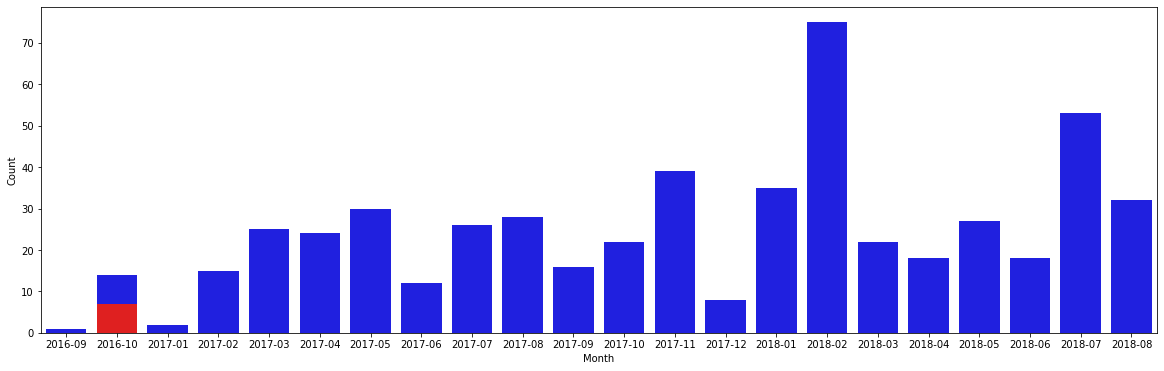

In [3]:
# Нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаю данные, в ДФ orders меняю тип колонки order_purchase_timestamp на datetime64[ns],
# чтобы в следующих шагах извлечь месяц
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates =['order_purchase_timestamp'])
order_items = pd.read_csv('olist_order_items_dataset.csv')

# Объединяю два ДФ (olist_orders_dataset и olist_order_items_dataset) по order_id
# для того, чтобы точно знать, что в заказе были какие либо товары, 
# возможные пустые заказы (сделанные пользователями, например, случайно) считать, как мне кажется, не стоит, 
# иначе возникнет неточность
merge_orders_and_order_items = pd.merge(orders, order_items, on = 'order_id') 

# Создаю новый столбец с месяцами с точки зрения создания заказа (order_purchase_timestamp)
# Использую .dt.to_period('M'), потому что наблюдения проводились несколько лет, 
# если использовать dt.month, то месяца объединятся, будет только 12 строк
merge_orders_and_order_items['month'] = merge_orders_and_order_items.order_purchase_timestamp.dt.to_period('M')

# Сортирую order_status только на отмененные и недоступные
order_status_unavailable_and_canceled = merge_orders_and_order_items.query('order_status in ["unavailable", "canceled"]')

# Считаю кличество всех отмененных/недоступных заказов относительно разных месяцев
order_status_unavailable_and_canceled = order_status_unavailable_and_canceled.groupby('month').size()

# Считаю среднее и округляю его до целого 
average = order_status_unavailable_and_canceled.mean().round(0)

# Не совсем понял "(вывести детализацию по причинам)"
# поэтому решил вывести еще ДФ-мы с количеством всех отмененных/недоступных заказов по месяцам отдельно
order_status_unavailable = merge_orders_and_order_items.query('order_status == "unavailable"')
order_status_unavailable = order_status_unavailable.groupby('month').size().reset_index(name='unavailable')

order_status_canceled = merge_orders_and_order_items.query('order_status == "canceled"')
order_status_canceled = order_status_canceled.groupby('month').size().reset_index(name='canceled')

# Вывожу результаты
print(f'{average} заказов в среднем в месяц не доставляется по разным причинам.')
print('Детализация причин:')
print(order_status_unavailable)
print(order_status_canceled)
print('График с отмененными/недоступными заказами по месяцам:')
print('Красный - заказы ставшие недоступными, Синий - отмененные заказы')

# Так же решил добавить barplot для наглядности
# how='outer' - потому что в ДФ order_status_unavailable меньше строк, чем в order_status_canceled
order_statuses = pd.merge(order_status_unavailable, order_status_canceled, on='month', how='outer')
# Сортирую по возрастанию месяцев, чтобы было корректное отображение на графике,
# без sort_values недоступные заказы накладывались на 2016-09 отмененных
order_statuses = order_statuses.sort_values(by='month')
# Дальше все и так понятно: размер, цвет, подписи, показать:)
plt.figure(figsize=(20, 6))
sns.barplot(order_statuses.month, order_statuses.canceled, color='blue')
sns.barplot(order_statuses.month, order_statuses.unavailable, color='red')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

3) Определить для каждого товара день недели, в который он чаще всего покупается.

In [4]:
# Нужная библиотека
import pandas as pd

# Загружаю данные, в ДФ orders меняю тип колонки order_purchase_timestamp на datetime64[ns],
# чтобы в следующих шагах извлечь дни недели
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates =['order_purchase_timestamp'])
order_items = pd.read_csv('olist_order_items_dataset.csv')

# Объединяю два ДФ (olist_orders_dataset и olist_order_items_dataset) по order_id,
# потому что в ДФ orders есть информация о дате, а в order_items есть информация о id-шниках товаров
merge_orders_and_order_items = pd.merge(orders, order_items, on = 'order_id')

# Также добавляю новый столбец day при помощи .dt.weekday, он будет показывать день недели (0-6)
merge_orders_and_order_items['day'] = merge_orders_and_order_items.order_purchase_timestamp.dt.weekday

# Создаю новый ДФ, где объединяю id-шник товара и день недели, 
# считаю количество встречаемости конкретных id-шников в определенный день недели и записываю это в новый столбец all_purchases
all_purchases_sum = merge_orders_and_order_items.groupby(['product_id', 'day']).size().reset_index(name='all_purchases')

# Нахожу максимальное значение all_purchases относительно каждого уникального id-шника
all_purchases_sum_max = all_purchases_sum.groupby('product_id')['all_purchases'].idxmax()

# Вывожу финальный ДФ при помощи loc (фильтрую all_purchases_sum относительно условий all_purchases_sum_max)
answer = all_purchases_sum.loc[all_purchases_sum_max]

# print результата
print(answer)

# Еще проверил при помощи order_items.product_id.nunique() количество уникальных id-шников
# Их получилось 32951, что равно строкам answer - 32951 rows, 
# тем самым, ни один уникальный товар не потерял и с задачей вроде справился

                             product_id  day  all_purchases
0      00066f42aeeb9f3007548bb9d3f33c38    6              1
1      00088930e925c41fd95ebfe695fd2655    1              1
2      0009406fd7479715e4bef61dd91f2462    3              1
3      000b8f95fcb9e0096488278317764d19    2              1
5      000d9be29b5207b54e86aa1b1ac54872    1              1
...                                 ...  ...            ...
61221  fff6177642830a9a94a0f2cba5e476d1    5              1
61223  fff81cc3158d2725c0655ab9ba0f712c    0              1
61224  fff9553ac224cec9d15d49f5a263411f    4              1
61225  fffdb2d0ec8d6a61f0a0a0db3f25b441    1              2
61229  fffe9eeff12fcbd74a2f2b007dde0c58    2              1

[32951 rows x 3 columns]


4) Рассчитать среднее количество покупок в неделю для каждого пользователя (по месяцам), учитывая возможные нецелые количество недель в месяце.

                     customer_unique_id    month  week  orders     avg
70504  b7d76e111c89f7ebf14761390f0f7d17  2016-09  4.29       1  0.2331
27787  4854e9b3feff728c13ee5fc7d1547e92  2016-09  4.29       1  0.2331
50307  830d5b7aaa3b6f1e9ad63703bec97d23  2016-09  4.29       1  0.2331
242    009b0127b727ab0ba422f6d9604487c7  2016-09  4.29       1  0.2331
79611  cfbb7c1c3d613d974eef515b180e2c9b  2016-10  4.43       1  0.2257
...                                 ...      ...   ...     ...     ...
57680  968fac81e2c44fb6c1e3ac2a45e6a102  2018-09  4.29       1  0.2331
38121  634420a0ea42302205032ed44ac7fccc  2018-10  4.43       1  0.2257
67306  af5454198a97379394cacf676e1e96cb  2018-10  4.43       1  0.2257
14656  262e1f1e26e92e86375f86840b4ffd63  2018-10  4.43       1  0.2257
52004  87ab9fec999db8bd5774917de3cdf01c  2018-10  4.43       1  0.2257

[98046 rows x 5 columns]
0.2257    58711
0.2331    29857
0.2500     8152
0.4515      754
0.4662      350
0.5000      163
0.6772       32
0.6993    

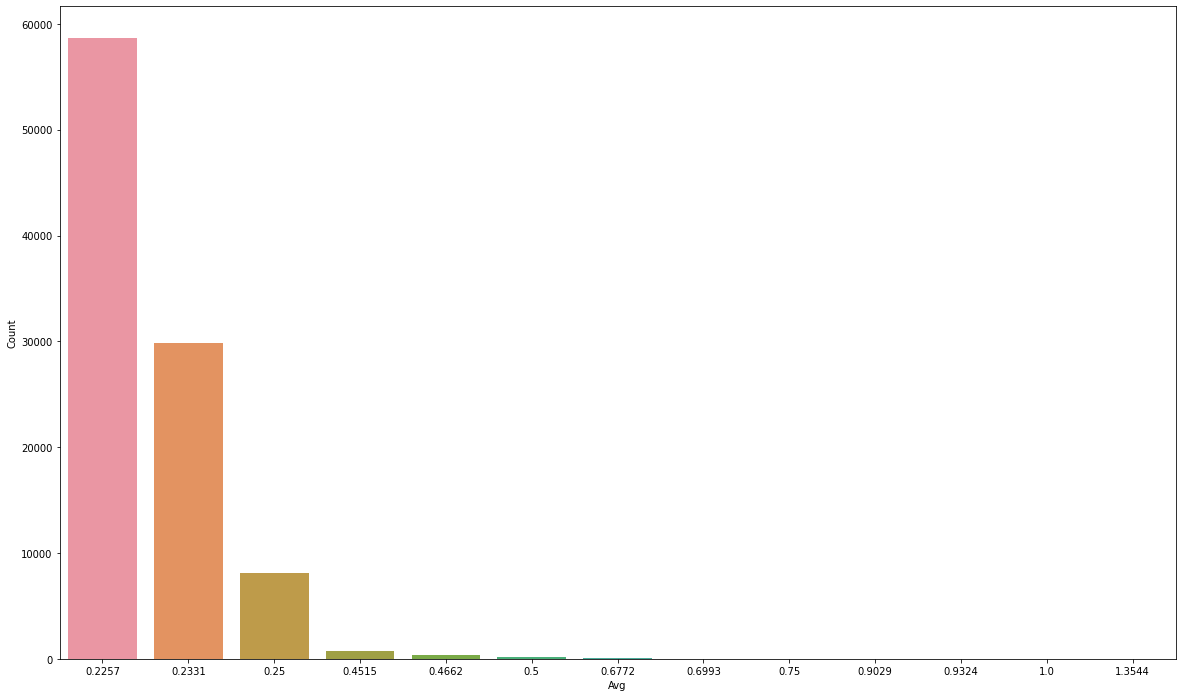

In [1]:
# Нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаю данные, в ДФ orders меняю тип колонки order_purchase_timestamp на datetime64[ns],
# чтобы в следующих шагах извлечь месяца
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates =['order_purchase_timestamp'])

# Мёржу ДФ-ы по customer_id
merge_orders_customers = pd.merge(customers, orders, on = 'customer_id')

# Идея та же, что и во 2-ом задании, нужно учитывать еще и разные годы
merge_orders_customers['month'] = merge_orders_customers.order_purchase_timestamp.dt.to_period('M')

# Создаю новый ДФ, в котором считаю количество заказов каждого уникального пользователя 
# (я считаю, что customer_unique_id куда лучше будет отражать всю историю заказов, 
# так как у некоторых уникальных юзеров может быть по несколько аккаунтов "customer_id — позаказный идентификатор пользователя",
# или я просто что то неправильно понимаю, поэтому решил перестраховаться)
month_orders_count = merge_orders_customers.groupby(['customer_unique_id', 'month']).size().reset_index(name = 'orders_count')

# Нашел на бесконечных форумах как можно посчитать число недель при помощи lambda, округляю до двух знаков, 
# чтобы было как в условии задачи
month_orders_count['week'] = month_orders_count['month'].apply(lambda x: x.days_in_month / 7).round(2)

# Вроде как это лишнее действие, но на всякий случай решил просуммировать заказы по месяцам уникальных айдишников,
# чтобы быть уверенным, что точно ничего не потерял, также отсортировал ДФ по возрастанию месяцев
avg_unique_id_week = month_orders_count.groupby(['customer_unique_id', 'month', 'week'])['orders_count'].sum().reset_index(name = 'orders').sort_values(by='month')

# Финальное действие для нахождения среднего - делю все "месячные" заказы каждого уник.id на число недель в конкретном месяце. 
avg_unique_id_week['avg'] = (month_orders_count.orders_count / month_orders_count.week).round(4)

# Вывожу результаты вычислений
print(avg_unique_id_week)



# Еще решил посчитать число id-шников с одинаковым средним
sorting_avg_unique_id_week = avg_unique_id_week['avg'].value_counts().sort_index()
# Получается, что с увеличением среднего заказов кол-во людей значительно уменьшается, что звучит логично
print(sorting_avg_unique_id_week)
# Вывожу барплот sorting_avg_unique_id_week
plt.figure(figsize=(20, 12))
sns.barplot(x=sorting_avg_unique_id_week.index, y=sorting_avg_unique_id_week.values)
plt.xlabel('Avg')
plt.ylabel('Count')
plt.show()


5) Провести когортный анализ пользователей, выявив когорту с самым высоким retention на 3-й месяц.

In [45]:
# Нужная библиотека
import pandas as pd

# Загружаю данные, в ДФ orders меняю тип колонки order_purchase_timestamp на datetime64[ns],
# чтобы в следующих шагах извлечь месяца
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates =['order_purchase_timestamp'])

# Мёржу ДФ-ы по customer_id
merge_orders_customers = pd.merge(customers, orders, on = 'customer_id')

# Идея та же, что и во 2-ом задании, нужно учитывать еще и разные годы
merge_orders_customers['month'] = merge_orders_customers.order_purchase_timestamp.dt.to_period('M')


# Определяю когорты, беру значения, которые встречаются в определенный месяц 
# (с января по декабрь в данных только 2017 год подходит под это условие, 16 и 18 неполнные)
cogort_01 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-01')]
cogort_02 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-02')]
cogort_03 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-03')]
cogort_04 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-04')]
cogort_05 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-05')]
cogort_06 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-06')]
cogort_07 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-07')]
cogort_08 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-08')]
cogort_09 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-09')]
cogort_10 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-10')]
cogort_11 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-11')]
cogort_12 = merge_orders_customers[merge_orders_customers['month'] == pd.Period('2017-12')]

# Считаю колво всех уникальных айдишников
cogort_01_users = cogort_01['customer_unique_id'].nunique()
cogort_02_users = cogort_02['customer_unique_id'].nunique()
cogort_03_users = cogort_03['customer_unique_id'].nunique()
cogort_04_users = cogort_04['customer_unique_id'].nunique()
cogort_05_users = cogort_05['customer_unique_id'].nunique()
cogort_06_users = cogort_06['customer_unique_id'].nunique()
cogort_07_users = cogort_07['customer_unique_id'].nunique()
cogort_08_users = cogort_08['customer_unique_id'].nunique()
cogort_09_users = cogort_09['customer_unique_id'].nunique()
cogort_10_users = cogort_10['customer_unique_id'].nunique()

# Определяю количество юзеров, которые совершили заказ спустя 3 месяца, сортирую при помощи .isin (True or False)
cogort_01_03_month_users = cogort_03[cogort_03['customer_unique_id'].isin(cogort_01['customer_unique_id'])]['customer_unique_id'].nunique()
cogort_02_04_month_users = cogort_04[cogort_04['customer_unique_id'].isin(cogort_02['customer_unique_id'])]['customer_unique_id'].nunique()
cogort_03_05_month_users = cogort_05[cogort_05['customer_unique_id'].isin(cogort_03['customer_unique_id'])]['customer_unique_id'].nunique()
cogort_04_06_month_users = cogort_06[cogort_06['customer_unique_id'].isin(cogort_04['customer_unique_id'])]['customer_unique_id'].nunique()
cogort_05_07_month_users = cogort_07[cogort_07['customer_unique_id'].isin(cogort_05['customer_unique_id'])]['customer_unique_id'].nunique()
cogort_06_08_month_users = cogort_08[cogort_08['customer_unique_id'].isin(cogort_06['customer_unique_id'])]['customer_unique_id'].nunique()
cogort_07_09_month_users = cogort_09[cogort_09['customer_unique_id'].isin(cogort_07['customer_unique_id'])]['customer_unique_id'].nunique()
cogort_08_10_month_users = cogort_10[cogort_10['customer_unique_id'].isin(cogort_08['customer_unique_id'])]['customer_unique_id'].nunique()
cogort_09_11_month_users = cogort_11[cogort_11['customer_unique_id'].isin(cogort_09['customer_unique_id'])]['customer_unique_id'].nunique()
cogort_10_12_month_users = cogort_12[cogort_12['customer_unique_id'].isin(cogort_10['customer_unique_id'])]['customer_unique_id'].nunique()

# Считаю Retention, те делю юзеров, купивших снова спустя 3 месяца, на число айдишников с момента отсчета, домножаю на 100 для % 
retention_cogort_01 = ((cogort_01_03_month_users / cogort_01_users) * 100)
retention_cogort_02 = ((cogort_02_04_month_users / cogort_02_users) * 100)
retention_cogort_03 = ((cogort_03_05_month_users / cogort_03_users) * 100)
retention_cogort_04 = ((cogort_04_06_month_users / cogort_04_users) * 100)
retention_cogort_05 = ((cogort_05_07_month_users / cogort_05_users) * 100)
retention_cogort_06 = ((cogort_06_08_month_users / cogort_06_users) * 100)
retention_cogort_07 = ((cogort_07_09_month_users / cogort_07_users) * 100)
retention_cogort_08 = ((cogort_08_10_month_users / cogort_08_users) * 100)
retention_cogort_09 = ((cogort_09_11_month_users / cogort_09_users) * 100)
retention_cogort_10 = ((cogort_10_12_month_users / cogort_10_users) * 100)

# Нахожу максимальное значение для ответа
max_retention_cogort = max(retention_cogort_01, 
                       retention_cogort_02, 
                       retention_cogort_03, 
                       retention_cogort_04, 
                       retention_cogort_05, 
                       retention_cogort_06, 
                       retention_cogort_07, 
                       retention_cogort_08, 
                       retention_cogort_09, 
                       retention_cogort_10)


# Есть способ сделать это задание проще, это очевидно:(
# пытался через цикл все сделать - получал миллион ошибок, но это уже проблема во мне видимо, хаха

# И как я понял, нужно для всех месяцев в интервале [01,12] (до 10 месяца) расчитать эту метрику

# Не могу избавиться от ощущения, что я делаю что то не так, слишком уж мало процентов получил,
# хотя если предположить, что это магазин условных элитных туфель, то выглядит очень даже реалистично, 
# далеко не каждый будет покупать каждые несколько месяцев новую пару

# Вывожу ответ 
print('Retention для когорты 1:', retention_cogort_01, '%')
print('Retention для когорты 2:', retention_cogort_02, '%')
print('Retention для когорты 3:', retention_cogort_03, '%')
print('Retention для когорты 4:', retention_cogort_04, '%')
print('Retention для когорты 5:', retention_cogort_05, '%')
print('Retention для когорты 6:', retention_cogort_06, '%')
print('Retention для когорты 7:', retention_cogort_07, '%')
print('Retention для когорты 8:', retention_cogort_08, '%')
print('Retention для когорты 9:', retention_cogort_09, '%')
print('Retention для когорты 10:', retention_cogort_10, '%')
print('MAX Retention:', max_retention_cogort, '%')

Retention для когорты 1: 0.261437908496732 %
Retention для когорты 2: 0.2849002849002849 %
Retention для когорты 3: 0.3785011355034065 %
Retention для когорты 4: 0.25295109612141653 %
Retention для когорты 5: 0.5241379310344828 %
Retention для когорты 6: 0.37735849056603776 %
Retention для когорты 7: 0.40537116797567774 %
Retention для когорты 8: 0.4710315591144607 %
Retention для когорты 9: 0.6172839506172839 %
Retention для когорты 10: 0.263100197325148 %
MAX Retention: 0.6172839506172839 %


6) Построить RFM-сегментацию пользователей. Для кластеризации выбрать метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно описать процесс создания кластеров. Для каждого RFM-сегмента указать границы метрик recency, frequency и monetary для интерпретации кластеров.


In [9]:
# Нужные библиотеки
import pandas as pd
from datetime import timedelta

# Все ДФ-ы
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp'])
order_items = pd.read_csv('olist_order_items_dataset.csv')

# Мержу их
merge_orders_customers = pd.merge(customers, orders, on='customer_id')
merge_orders_customers_order_items = pd.merge(merge_orders_customers, order_items, on='order_id')

# Беру только доставленные заказы
start_rfm = merge_orders_customers_order_items.query('order_status == "delivered"')

# Оставляю только нужные для расчетов столбцы 
start_rfm = start_rfm[['customer_unique_id', 'order_id', 'price', 'order_purchase_timestamp']]

# Определяю новую переменную на один день после последней покупки, 
# это нужно для посчета очков Recency в качестве ориентира
now = start_rfm['order_purchase_timestamp'].max() + timedelta(days=1)

# Периодом определяю раницу последнего заказа с первым, 
# дополнительно вычитаю часы-минуты-секунды и добавляю 1 день, для ровного счета
period = start_rfm['order_purchase_timestamp'].max() - start_rfm['order_purchase_timestamp'].min() - timedelta(hours=2, minutes=43, seconds=59) + timedelta(days=1)

# Добавил столбец, как в примере, в котором будет указано количество дней 
# между датой покупки и датой now 
start_rfm['days_since_order'] = start_rfm['order_purchase_timestamp'].apply(lambda x: (now - x).days)

# Созаю ДФ для Recency и Frequency
aggr = {
#     Определяю недавность последнего заказа
    'days_since_order': lambda x: x.min(),
#     Общее количество заказов за период 
    'order_purchase_timestamp': lambda x: len([d for d in x if d >= now - period])
        }

# Применяю вычисления для каждого уникального айдишника
now_rfm = start_rfm.groupby('customer_unique_id').agg(aggr).reset_index()

# Переименовываю столбцы
now_rfm.rename(columns={'days_since_order': 'Recency', 'order_purchase_timestamp': 'Frequency'}, inplace=True)

# Считаю сумму потраченных денег у каждого айдишкника
monetary = start_rfm.groupby('customer_unique_id', as_index=False)['price'].sum()
monetary.rename(columns={'price': 'Monetary'}, inplace=True)

# Мержу monetary с текущим ДФ-ом
now_rfm = now_rfm.merge(monetary, on='customer_unique_id')

# Для расчета баллов каждого параметра считаю квантили, 
# определяю 5 групп, как в примере (по 20%)
quintiles = now_rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

# quintiles дает следующий вывод, где Frequency считается, 
# как мне казалось некорректно

# {'Recency': {0.2: 92.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
#  'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
#  'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

# Тем самым посчитал частоту, где 1 = 81748 покупкам, а значит,
# что квантили посчитались верно (каждая группа получает балл, который
# минимально отличается от единицы)

# Frequency:
# 1     81748
# 2      8797
# 3      1645
# 4       621
# 5       241
# 6       190
# 7        45
# 8        16
# 11       11
# 10       11
# 9        10
# 12        9
# 15        3
# 14        3
# 20        2
# 13        2
# 24        1
# 21        1
# 18        1

# Принял решение считать частоту вручную разбив на группы
# присваиваю баллы: 
# до 2 заказов - 1, от 2 до 5 - 2, от 5 до 10 - 3, от 10 до 20 - 4, больше 20 - 5

def frequency(Frequency):
    if Frequency <= 2:
        return 1
    elif Frequency <= 5:
        return 2
    elif Frequency <= 10:
        return 3
    elif Frequency <= 20:
        return 4
    else:
        return 5

# Недавность или новизну считаю следующим образом:
# до значения квантиля 0.2 - 5, от 0.2 до 0.4 - 4, от 0.4 до 0.6 - 3,
# от 0.6 до 0.8 - 2, больше 0.8 - 1 

# считаю в обратной последовательности тк 
# более высокие значения "недовности" куда лучше, чем низкие 
def recency(Recency):
    if Recency <= quintiles['Recency'][.2]:
        return 5
    elif Recency <= quintiles['Recency'][.4]:
        return 4
    elif Recency <= quintiles['Recency'][.6]:
        return 3
    elif Recency <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

# Monetary так:
# до значения квантиля 0.2 - 1, от 0.2 до 0.4 - 2, от 0.4 до 0.6 - 3,
# от 0.6 до 0.8 - 4, больше 0.8 - 5
def monetary(Monetary):
    if Monetary <= quintiles['Monetary'][.2]:
        return 1
    elif Monetary <= quintiles['Monetary'][.4]:
        return 2
    elif Monetary <= quintiles['Monetary'][.6]:
        return 3
    elif Monetary <= quintiles['Monetary'][.8]:
        return 4
    else:
        return 5


# Разбиение на группы этих трех величин напрямую зависит от контекста задачи, я решил сделать так:
# чем больше значения частоты - тем лучше
# чем ближе значения Recency к концу исследуемого промежутка - эти клиенты более "важные" для бизнеса 
# чем больше денег потратил клиент - тем лучше бизнесу
    

# применяю def-ы
now_rfm['F'] = now_rfm['Frequency'].apply(lambda x: frequency(x))
now_rfm['R'] = now_rfm['Recency'].apply(lambda x: recency(x))
now_rfm['M'] = now_rfm['Monetary'].apply(lambda x: monetary(x))

# обединяю для каждой строки в RFM, проще всего поменять тип на string, чтобы "приклеить" значения
now_rfm['RFM'] = now_rfm.R.astype(str) + now_rfm.F.astype(str) + now_rfm.M.astype(str)

# Вывожу нужные колонки
now_rfm = now_rfm[['customer_unique_id', 'R', 'F', 'M', 'RFM']]
now_rfm

# Ради интереса можно описать конкретного пользователя, я взял первого 
# 0   0000366f3b9a7992bf8c76cfdf3221e2  4  1  4   414
# С учетом этих данных можно сделать вывод, что данный юзер
# делал покупки относительно давно, закупался малым количеством товара, но потратил на них достаточно крупную сумму, 
# ТЕ пользователь покупает относительно дорогие вещи, но не очень часто


,customer_unique_id,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4,1,1,411
2,0000f46a3911fa3c0805444483337064,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,2,1,5,215
...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,1,5,115
93354,fffea47cd6d3cc0a88bd621562a9d061,3,1,2,312
93355,ffff371b4d645b6ecea244b27531430a,1,1,3,113
93356,ffff5962728ec6157033ef9805bacc48,4,1,4,414
